In [5]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import matplotlib
import matplotlib.ticker as ticker
from pymcaspec import specfile
import matplotlib as mpl
import lmfit
import matplotlib.colors as col
import matplotlib.cm as cm
from ase.io import read
import copy
import matplotlib.patches as patches
import colorsys
from PIL import Image
#from utils import load_var
#plt.rcParams['text.usetex'] = True
import numbers

mpl.rc('lines', markersize=3)
colors = [f'C{i}' for i in range(10)]
font = {'size' : 7}
matplotlib.rc('font', **font)

In [6]:
# Some function definitions

def gen_cmap(N, cmap = 'seismic'):
    color_norm = col.Normalize(vmin = 0, vmax = N-1)
    scalar_map = cm.ScalarMappable(norm = color_norm, cmap = cmap)
    def map_index_to_rgb(index):
        return scalar_map.to_rgba(index, 1)
    return map_index_to_rgb

def rixsDataReader(data_folder, scan, spectrum_name='SPC', xshift = 0, interp=False, x_ref=None, scale = 1, norm=False, 
                   monitor_name='Mirror current / 1e6'): 
    f = specfile(data_folder)
    s = f[scan]
    x = -s['Energy (eV)'][::-1]
    y = s[spectrum_name][::-1]
    
    x = x + xshift
    yerr = np.sqrt(y)

    if interp and isinstance(x_ref, (list, np.ndarray)):
        y = np.interp(x_ref,x,y)
        yerr = np.sqrt(y)
        x = x_ref
    
    if norm:
        norm_factor = s[monitor_name][::-1]
        y = y / norm_factor
        yerr = yerr / norm_factor
        
    y = y * scale
    yerr = yerr * scale
    return x, y, yerr

def mybin(x,y,yerr, binsize):
    new_x = []
    new_y = []
    new_yerr = []
    index = len(x)
    for i in range(0,index, binsize): #n is index, i is value      
        new_x.append(np.mean(x[i:i+binsize]))
        new_y.append(np.mean(y[i:i+binsize]))
        new_yerr.append(np.sqrt(np.mean(yerr[i:i+binsize]**2)))  
    new_x = np.array(new_x)
    new_y = np.array(new_y)
    new_yerr = np.array(new_yerr)
    
    return new_x, new_y, new_yerr

def plot2d(ax, x, y, Int, colormap='jet',shading='nearest'):
    x = np.array(x)
    y = np.array(y)
    if len(x) != np.shape(Int)[0]:
        print("wrong dimension for x, should be the same as the 1st dimension of Int\n")
    elif len(y) != np.shape(Int)[1]:
        print("wrong dimension for y, should be the same as the 2nd dimension of Int\n")
    else:
        x_mesh,y_mesh = np.meshgrid(x,y)
        im = ax.pcolormesh(x_mesh,y_mesh,np.fliplr(np.rot90(Int, k=-1)),
                           shading=shading, #'nearest', 'gouraud'
                           cmap=colormap, 
                          )
        return im

def myrixs2d(data_folder, scans, ax, x_axis, spectrum_name='SPC', colormap='jet', xshift=0, scale=1, norm=False, 
             monitor_name='Mirror current / 1e6', binsize=1, shading='nearest'):
    
    Int = []
    if isinstance(xshift, (list, np.ndarray)):
        xshift = np.array(xshift)
    elif isinstance(xshift, numbers.Number):
        xshift = np.ones(len(scans)) * xshift
    else:
        print('wrong input type for xshift, must be a number, a list, or a numpy array')
    
    if isinstance(scale, (list, np.ndarray)):
        scale = np.array(scale)
    elif isinstance(scale, numbers.Number):
        scale = np.ones(len(scans)) * scale
    else:
        print('wrong input type for xshift, must be a number, a list, or a numpy array')
        
        
    for i in range(len(scans)):
        scan = scans[i]
        if i == 0:
            x,y, yerr = rixsDataReader(data_folder=data_folder, scan=scan, spectrum_name=spectrum_name, xshift=xshift[i], 
                                       interp=False, scale=scale[i], norm=norm, monitor_name=monitor_name,)
            x_ref = x
            x_binned,y_binned,yerr_binned = mybin(x,y,yerr, binsize)
        else:
            x,y, yerr = rixsDataReader(data_folder=data_folder, scan=scan, spectrum_name=spectrum_name, xshift=xshift[i], 
                                       interp=True, x_ref = x_ref, scale=scale[i], norm=norm, monitor_name=monitor_name,)
            x_binned,y_binned,yerr_binned = mybin(x,y,yerr, binsize)
        Int.append(y_binned)
    Int = np.concatenate(Int)
    Int = Int.reshape(x_axis.size, x_binned.size)
    im = plot2d(ax=ax, x=x_axis, y=x_binned, Int=Int, colormap=colormap, shading=shading)
        
    return im

def absorptionFactor(th, tth, thickness, penetrationDepth):
    th_i = np.deg2rad(th)
    th_o = np.deg2rad(tth - th)
    A = np.sin(th_o) / (np.sin(th_i)+np.sin(th_o))
    return A * (1 - np.exp(-thickness/A/penetrationDepth/np.sin(th_i)))

def gauss(x, cen, amp, sig):
    sig = np.clip(sig, 1e-6, 1e10)
    return amp/sig/np.sqrt(2*3.14159)*np.exp(-(x-cen)**2/2/sig**2)

def twogauss(x, cen1, amp1, sig1, cen2, amp2, sig2,  cen3, amp3, sig3, cen4, amp4, sig4, const):
    return gauss(x, cen1, amp1, sig1) + gauss(x, cen2, amp2, sig2) + gauss(x, cen3, amp3, sig3)+ gauss(x, cen4, amp4, sig4)+const

def gen_cmap(N, cmap = 'seismic'):
    color_norm = col.Normalize(vmin = 0, vmax = N-1)
    scalar_map = cm.ScalarMappable(norm = color_norm, cmap = cmap)
    def map_index_to_rgb(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb

In [7]:
# Scan information, and zero offsets

f = specfile('./Online_analysis_20220917_CrSBr_5_Tdep_00_dir.spec')
datafolder = './Online_analysis_20220917_CrSBr_5_Tdep_00_dir.spec'

scanlist = range(119, 125+1)
temps = np.array([30, 70, 110, 130, 140, 150, 200])
xshifts = np.array([0.0018982715185643412,
 0.005365763290116252,
 0.007077931247525938,
 0.0055429216857471675,
 0.005058594172309072,
 0.004369438299143994,
 0.0053165988818608245])
cmap = gen_cmap(len(scanlist), cmap = 'coolwarm')


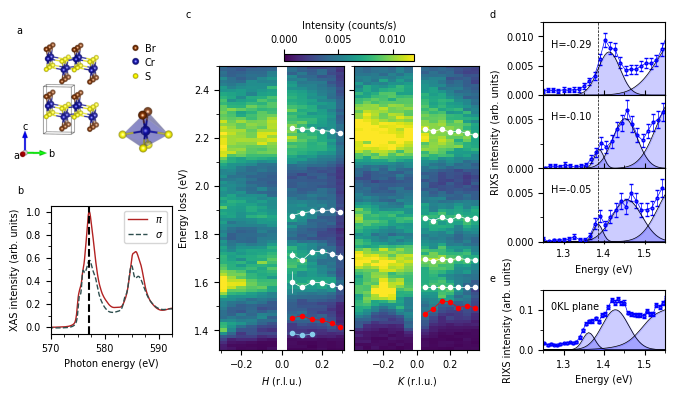

In [8]:
# Make the figure and subplots
fig = plt.figure(figsize=((3+3/8)*2, 4.))

# Maps
hh = 0.37/2
ax2 = fig.add_axes((.52, .13, hh, 0.85))
ax1 = fig.add_axes((.32, .13, hh, 0.85))
ax1a = fig.add_axes([0.07, 0.17, 0.18, 0.32]) #XAS
ax2a = fig.add_axes([.01, 0.53, 0.25, 0.45]) #structure
axd1 = fig.add_axes([0.8, 0.4+2*0.55/3, 0.18, 0.55/3]) 
axd2 = fig.add_axes([0.8, 0.4+0.55/3, 0.18, 0.55/3]) 
axd3 = fig.add_axes([0.8, 0.4, 0.18, 0.55/3]) 
axe = fig.add_axes([0.8, 0.13, 0.18, 0.15]) 


im = Image.open('./structure.png')
ax2a.imshow(im)
# Remove the axes 
ax2a.set_axis_off()
tt1 = -10
ax2a.text(1378, 145-tt1, 'Br')
ax2a.text(1378, 288-tt1, 'Cr')
ax2a.text(1378, 434-tt1, 'S')
ax2a.text(33, 1255, 'a')
ax2a.text(387, 1235, 'b')
ax2a.text(125, 953, 'c')


# XAS data
fl = np.load('xas_lh.npz')
yvals = (fl['xas']-fl['xas'][0])/(fl['xas'][-1]-fl['xas'][0])
ax1a.plot(fl['ein'], yvals/np.amax(yvals), color='firebrick', ls='-', lw=1, label=r'$\pi$')
fl = np.load('xas_lv.npz')
yvals1 = (fl['xas']-fl['xas'][0])/(fl['xas'][-1]-fl['xas'][0])
ax1a.plot(fl['ein'], yvals1/np.amax(yvals), color='darkslategray', ls='--', lw=1, label=r'$\sigma$')
ax1a.legend()
ax1a.axvline(x=577.2, color='k', ls='dashed')
ax1a.set_xlabel('Photon energy (eV)')
ax1a.set_ylabel('XAS intensity (arb. units)')
ax1a.set_xlim(570, 592.5)
ax1a.xaxis.set_minor_locator(ticker.MultipleLocator(2.5))
ax1a.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax1a.yaxis.set_major_locator(ticker.MultipleLocator(0.2))

fig.text(0.02, 0.92, 'a')
fig.text(0.27, 0.96, 'c')
fig.text(0.02, 0.52, 'b')
fig.text(0.72, 0.96, 'd')
fig.text(0.72, 0.3, 'e')


# Maps
# Load the data; H0L
fh = specfile('./Online_analysis_20220914_CrSBr_5_dispersion_00_dir.spec')
datafolderh = './Online_analysis_20220914_CrSBr_5_dispersion_00_dir.spec'
scanlisth = range(20, 31+1)
# Sort the scanlist
hlist = []
for i, key in enumerate(scanlisth):
    s = fh[key]
    H = s.get_baseline('H')
    hlist.append(H)
sortlist = sorted(zip(hlist, scanlisth) )
scanlisth = [tt[1] for tt in sortlist]
hlist = [tt[0] for tt in sortlist]

# 0KL
fk = specfile('./Online_analysis_20220915_CrSBr_5_K_dispersion_00_dir.spec')
data_folderk = './Online_analysis_20220915_CrSBr_5_K_dispersion_00_dir.spec'
scanlistk = range(59, 72+1)
# Sort the scanlist
klist = []
for i, key in enumerate(scanlistk):
    s = fk[key]
    K = s.get_baseline('K')
    klist.append(K)
sortlist = sorted(zip(klist, scanlistk) )
scanlistk = [tt[1] for tt in sortlist]
klist = [tt[0] for tt in sortlist]

# Get the fitted peak positions
hdat = np.genfromtxt('./hdisp.txt')
kdat = np.genfromtxt('./kdisp.txt')

# Plot the map with the fitted peak positions
#################
# H0L
# Plot one side of the dispersion
scans = np.asarray(scanlisth[:6])
Ks = np.asarray(hlist[:6])
ths = np.array([9.4125, 23.8475, 36.9375, 47.9, 57.8175, 67.185,])
tth = 149
offlist = hdat[:,2]
xshifts = offlist[:6]
scales = absorptionFactor(th=ths, tth=tth, thickness=10e7, penetrationDepth=100)
scales = 1
norm = True
monitor_name = 'Mirror current / 1e6'
binsize = 4
shading = 'nearest'

cmap = gen_cmap(6, cmap = 'coolwarm')

# Plot the line cuts
for jj in [0, 4, 5]:
    offset = 0.006
    kval = hlist[jj]
    scan = scanlisth[jj]
    x, y, yerr = rixsDataReader(data_folder=datafolderh, scan=scan, spectrum_name='SPC', xshift=offlist[jj], interp=False, scale=1, norm=True, monitor_name=monitor_name,)
    x, y, yerr = mybin(x,y,yerr, 4)
    cen1 = hdat[jj, 3]
    amp1 = hdat[jj, 5]
    sig1 = hdat[jj, 7]
    cen2 = hdat[jj, 9]
    amp2 = hdat[jj, 11]
    sig2 = hdat[jj, 13]
    cen3 = hdat[jj, 15]
    amp3 = hdat[jj, 17]
    sig3 = hdat[jj, 19]
    if jj==0:
        axplot = axd1
        axd1.text(1.27, 0.008, 'H={:.2f}'.format(kval))
    if jj==4:
        axplot = axd2
        axd2.text(1.27, 0.005, 'H={:.2f}'.format(kval))
    if jj==5:
        axplot = axd3
        axd3.text(1.27, 0.005, 'H={:.2f}'.format(kval))
    axplot.errorbar(x, y, yerr, marker='o', capsize=1.5, mfc='None', color='blue', ms=2, lw=0.5)
    xfit = np.linspace(1, 2, 200)
    axplot.plot(xfit, gauss(xfit, cen1, amp1, sig1), color='k', lw=0.5 )
    axplot.fill_between(
             x= xfit, 
             y1= gauss(xfit, cen1, amp1, sig1), 
             color= "b",
             alpha= 0.2) 
    axplot.plot(xfit, gauss(xfit, cen2, amp2, sig2), color='k', lw=0.5 )
    axplot.fill_between(
             x= xfit, 
             y1= gauss(xfit, cen2, amp2, sig2), 
             color= "b",
             alpha= 0.2) 
    axplot.plot(xfit, gauss(xfit, cen3, amp3, sig3), color='k', lw=0.5 )
    axplot.fill_between(
             x= xfit, 
             y1= gauss(xfit, cen3, amp3, sig3), 
             color= "b",
             alpha= 0.2) 
    
axd1.set_xlim(1.25, 1.55)
axd2.set_xlim(1.25, 1.55)
axd3.set_xlim(1.25, 1.55)
axd1.set_ylim(0, 0.0125)
axd2.set_ylim(0, 0.0075)
axd3.set_ylim(0, 0.0075)

axd1.axvline(x=1.385, ls='dashed', color='k', lw=0.5)
axd2.axvline(x=1.385, ls='dashed', color='k', lw=0.5)
axd3.axvline(x=1.385, ls='dashed', color='k', lw=0.5)

axd3.set_xlabel('Energy (eV)')
axd2.set_ylabel('RIXS intensity (arb. units)')
axd1.yaxis.set_minor_locator(ticker.MultipleLocator(0.0025))
axd2.yaxis.set_minor_locator(ticker.MultipleLocator(0.0025))
axd3.yaxis.set_minor_locator(ticker.MultipleLocator(0.0025))
axd1.yaxis.set_major_locator(ticker.MultipleLocator(0.005))
axd2.yaxis.set_major_locator(ticker.MultipleLocator(0.005))
axd3.yaxis.set_major_locator(ticker.MultipleLocator(0.005))

axd1.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
axd2.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
axd3.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))

axd1.set_xticklabels([])
axd2.set_xticklabels([])

axd1.tick_params(axis='x', direction='in',  which='both')
axd2.tick_params(axis='x', direction='in',  which='both')
axd3.tick_params(axis='x', direction='inout', which='both')


im1 = myrixs2d(datafolderh, scans=scans, ax=ax1, x_axis=Ks[0:6], spectrum_name='SPC', colormap='viridis', 
               xshift=xshifts, scale=1/scales, norm=norm, monitor_name=monitor_name, binsize=binsize, shading=shading)

# Plot the other side of the dispersion
scans = np.asarray(scanlisth[6:])
Ks = np.asarray(hlist[6:])
ths = np.array([85.435, 94.8025, 104.7175, 115.68, 128.77, 143.2075,])
xshifts = offlist[6:]
scales = absorptionFactor(th=ths, tth=tth, thickness=10e7, penetrationDepth=100)
scales = 1

norm = True
monitor_name = 'Mirror current / 1e6'

shading = 'nearest'

im2 = myrixs2d(datafolderh, scans=scans, ax=ax1, x_axis=Ks[0:6], spectrum_name='SPC', colormap='viridis', 
               xshift=xshifts, scale=1/scales, norm=norm, monitor_name=monitor_name, binsize=binsize, shading=shading)


######################################################
# Settings for the map
cmax = 0.012
ymin = 1.32
ymax = 2.5
im1.set_clim(0, cmax)
im2.set_clim(0, cmax)

ax1.set_xlim(-0.31,0.31)
ax1.set_ylim(ymin, ymax)
ax1.set_xlabel("$H$ (r.l.u.)")
ax1.set_ylabel("Energy loss (eV)")


# Plot the peak positions
ax1.errorbar(hlist[6:], hdat[6:,3], hdat[6:,4], marker='o', color='r' , lw=0.5)
ax1.errorbar(hlist[6:9], hdat[6:9,9], hdat[6:9,10], marker='o', color='skyblue' , lw=0.5)
ax1.errorbar(hlist[6:], hdat[6:,15], hdat[6:,16], marker='o', color='w' , lw=0.5)
ax1.errorbar(hlist[6:], hdat[6:,21], hdat[6:,22], marker='o', color='w' , lw=0.5)
ax1.errorbar(hlist[6:], hdat[6:,27], hdat[6:,28], marker='o', color='w' , lw=0.5)
ax1.errorbar(hlist[6:], hdat[6:,33], hdat[6:,34], marker='o', color='w' , lw=0.5)





#################
# 0KL
scans = np.asarray(scanlistk[:7])
Ks = np.asarray(klist[:7])
ths = np.array([20.11, 30.5875, 39.42, 47.355, 54.7375, 61.7775, 68.615, 82.095, 88.93, 95.9725, 103.355, 111.29, 120.122, 130.6])
tth = 149
offlist = kdat[:,2]
xshifts = offlist[:7]
scales = absorptionFactor(th=ths, tth=tth, thickness=10e7, penetrationDepth=100)
scales = 1
norm = True
monitor_name = 'Mirror current / 1e6'
shading = 'nearest'
im3 = myrixs2d(data_folderk, scans=scans, ax=ax2, x_axis=Ks[0:7], spectrum_name='SPC', colormap='viridis', 
               xshift=xshifts, scale=1/scales, norm=norm, monitor_name=monitor_name, binsize=binsize, shading=shading)

# Plot the other side of the dispersion
scans = np.asarray(scanlistk[7:])
Ks = np.asarray(klist[7:])
ths = np.array([ 82.095, 88.93, 95.9725, 103.355, 111.29, 120.122, 130.6])
xshifts = offlist[7:]
scales = absorptionFactor(th=ths, tth=tth, thickness=10e7, penetrationDepth=100)
scales = 1
norm = True
monitor_name = 'Mirror current / 1e6'
shading = 'nearest'
im4 = myrixs2d(data_folderk, scans=scans, ax=ax2, x_axis=Ks[0:7], spectrum_name='SPC', colormap='viridis', 
               xshift=xshifts, scale=1/scales, norm=norm, monitor_name=monitor_name, binsize=binsize, shading=shading)

######################################################
# Settings for the map
im3.set_clim(0, cmax)
im4.set_clim(0, cmax)
cbar = plt.colorbar(im4, ax=[ax1, ax2], shrink=0.5, label='Intensity (counts/s)', location='top', pad=0.015)

ax2.set_xlim(-0.375,0.375)
ax2.set_ylim(ymin, ymax)
ax2.set_xlabel("$K$ (r.l.u.)")
#ax2.set_ylabel("Energy loss (eV)",fontsize=14)


# Plot the peak positions
ax2.errorbar(klist[7:], kdat[7:,3], kdat[7:,4], marker='o', color='r' , lw=0.5)
ax2.errorbar(klist[7:], kdat[7:,9], kdat[7:,10], marker='o', color='w' , lw=0.5)
ax2.errorbar(klist[7:], kdat[7:,15], kdat[7:,16], marker='o', color='w' , lw=0.5)
ax2.errorbar(klist[7:], kdat[7:,21], kdat[7:,22], marker='o', color='w' , lw=0.5)
ax2.errorbar(klist[7:], kdat[7:,27], kdat[7:,28], marker='o', color='w' , lw=0.5)

ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax2.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))

# Plot the high resolution data from SIX
import h5py
from scipy.optimize import curve_fit

f = h5py.File('./six-239503_239508.hdf', 'r') #0KL
evals = np.ravel(f['data']['E'][:])
time = f['meta/total_time'][()].sum()
count_sec = f['data/rixs'][()]
counts = count_sec[:, 0]*time


p0=[1360,10000,20,   1430,30000,30,   1650,85000,50,   1550,40000,50, .012*time]
fit = curve_fit(twogauss, evals[329:382], counts[329:382], p0=p0)
xfit = np.linspace(1, 2, 200)

axe.plot(xfit, gauss(xfit*1000, fit[0][0], fit[0][1], fit[0][2])/time, color='k', lw=0.5 )
axe.fill_between( x= xfit, y1= gauss(xfit*1000, fit[0][0], fit[0][1], fit[0][2])/time, color= "b", alpha= 0.2) 
axe.plot(xfit, gauss(xfit*1000, fit[0][3], fit[0][4], fit[0][5])/time, color='k', lw=0.5 )
axe.fill_between( x= xfit, y1= gauss(xfit*1000, fit[0][3], fit[0][4], fit[0][5])/time, color= "b", alpha= 0.2) 
axe.plot(xfit, gauss(xfit*1000, fit[0][6], fit[0][7], fit[0][8])/time + gauss(xfit*1000, fit[0][9], fit[0][10], fit[0][11])/time, color='k', lw=0.5 )
axe.fill_between( x= xfit, y1= gauss(xfit*1000, fit[0][6], fit[0][7], fit[0][8])/time +gauss(xfit*1000, fit[0][9], fit[0][10], fit[0][11])/time, color= "b", alpha= 0.2) 
axe.errorbar(evals/1000, counts/time, counts**0.5/time, marker='o', capsize=1.5, mfc='None', color='blue', ms=2, lw=0.5)
axe.set_xlim(1.25, 1.55)
axe.set_ylim(0, 0.15)
axe.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
axe.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
axe.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
axe.set_xlabel('Energy (eV)')
axe.set_ylabel('RIXS intensity (arb. units)')
axe.text(1.27, 0.1, '0KL plane')

plt.show()